In [13]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='207d5c7c-6695-4afd-9021-7a319334df31', project_access_token='p-146db0e12cc0cdbb6edb15ebf706500e11bfdfce')
pc = project.project_context


In [47]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Rather than importing the whole sklearn library, we will inly import certain modules 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


churn_file = project.get_file("Bank_Churn_2020_Train-20200210.json") # returns BytesIO object from file name
churn_df = pd.read_json(churn_file)

In [48]:
churn_df = churn_df[churn_df.Gender.isin(['Male','Female'])]
churn_df = churn_df[churn_df.PlatStatus.isin(['0','1'])]##map a yes to 1
churn_df = churn_df[churn_df.Active.isin([0,1])]
churn_df = churn_df[churn_df.BankCC.isin([0,1])]
churn_df['PlatStatus'] = churn_df.PlatStatus.astype('int64')
churn_df['Gender'] = churn_df.Gender.astype('category')
churn_df['Subsidiary'] = churn_df.Subsidiary.astype('category')
subsidiary_columns = pd.get_dummies(churn_df['Subsidiary'])
churn_df = pd.merge(churn_df, subsidiary_columns, left_index = True, right_index = True)
churn_df['Gender_Num'] = churn_df.Gender.cat.codes
churn_df.head()

,Active,Age,Balance,BankCC,ClientID,FICOScore,Firstname,Gender,LifeInsur,PlatStatus,Products,RegDeposits,Subsidiary,Surname,Terminated,Atlanta,Boston,Chapel Hill,Gender_Num
0,0,37,122113.33,1,40ATL20120GM80095097706311P,624,Mindy,Female,1,1,2,5007,Atlanta,Graci,0,1,0,0,0
1,0,39,0.00,0,91CHL20100VI26913599075505N,670,Iraida,Female,1,0,2,7835,Chapel Hill,Veness,0,0,0,1,0
2,0,32,87992.57,0,61BOS20130LH10246893211788N,746,Hector,Male,0,0,1,8401,Boston,Latimore,0,0,1,0,1
3,0,36,1970.80,1,61BOS20150AC6028668471081P,796,Clifford,Male,1,1,2,8931,Boston,Aerts,0,0,1,0,1
4,0,49,83892.12,1,61BOS20190SR10901609271524N,584,Romeo,Male,0,0,1,8353,Boston,Swestka,1,0,1,0,1


In [49]:
def get_outliers(data, columns):
    # we create an empty list
    outlier_idxs = []
    nsd = 3 # number of standard deviations we keep. 
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

In [50]:
outlier_columns = ['Age', 'Balance', 'FICOScore', 'RegDeposits']
# we call the function we just created on the boston dataset
churn_outliers = get_outliers(churn_df, outlier_columns)
# and drop those records from our feature and response data
churn_df = churn_df.drop(churn_outliers, axis = 0)

In [51]:
churn_X = churn_df[['Active','Age','Balance','BankCC','FICOScore','LifeInsur','PlatStatus','RegDeposits','Gender_Num','Chapel Hill','Atlanta','Boston']]
churn_y = churn_df['Terminated']
print(churn_X.shape)
print(churn_y.shape)

(23735, 12)
(23735,)


In [ ]:
for col in churn_X.columns:
    # and for each column we create space for one row with 2 charts 
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    # our first chart is a histogram and we set the title 
    churn_X[col].hist(bins = 30, ax = axes[0])
    axes[0].set_title('Distribution of '+ col)
    # our second column is the boxplot 
    churn_X.boxplot(column = col, ax = axes[1])
    # we then use this to command to display the charts
    plt.show()

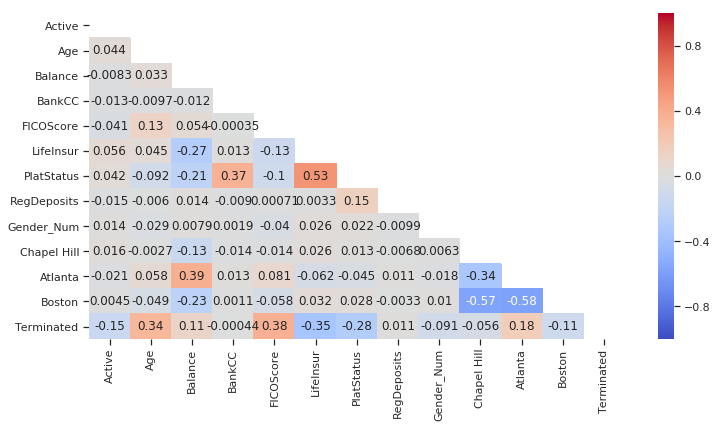

In [28]:
churn_corr = churn_df[['Active','Age','Balance','BankCC','FICOScore','LifeInsur','PlatStatus','RegDeposits','Gender_Num','Chapel Hill','Atlanta','Boston','Terminated']]
corr = churn_corr.corr()
plt.figure(figsize=(12,6))
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask);

In [52]:
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data
numeric_columns = ['Active','Age','Balance','BankCC','FICOScore','LifeInsur','PlatStatus','RegDeposits','Gender_Num','Chapel Hill','Atlanta','Boston']
churn_X = churn_X.astype('float64')
# we can now define the scaler we want to use and apply it to our dataset 
scaler = MinMaxScaler()
churn_X = scale_numeric(churn_X, numeric_columns, scaler)
churn_X.head()

,Active,Age,Balance,BankCC,FICOScore,LifeInsur,PlatStatus,RegDeposits,Gender_Num,Chapel Hill,Atlanta,Boston
0,0.0,0.392857,0.643387,1.0,0.466780,1.0,1.0,0.346999,0.0,0.0,1.0,0.0
1,0.0,0.428571,0.329732,0.0,0.545145,1.0,0.0,0.480565,0.0,1.0,0.0,0.0
2,0.0,0.303571,0.555746,0.0,0.674617,0.0,0.0,0.507297,1.0,0.0,0.0,1.0
3,0.0,0.375000,0.334794,1.0,0.759796,1.0,1.0,0.532329,1.0,0.0,0.0,1.0
4,0.0,0.607143,0.545213,1.0,0.398637,0.0,0.0,0.505030,1.0,0.0,0.0,1.0
